# Homework #3 Solutions
### Portfolio Theory and Risk Management I

## Imports

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

## Data

In [196]:
df = pd.read_excel('../data/barnstable_analysis_data.xlsx', sheet_name = 1)

df = df.set_index('date')

df.head()

,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0333,0.0026
1926-03-31,-0.0577,0.0026
1926-04-30,0.0385,0.0023
1926-05-28,0.0136,0.0027


In [197]:
log_df = np.log(1 + df)

log_df.head()

,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0339,0.0026
1926-03-31,-0.0594,0.0026
1926-04-30,0.0378,0.0023
1926-05-28,0.0135,0.0027


## 1 Barnstable's Analsyis

### 1.1 Barnstable's Philosophy
   
(a) What has Barnstable's investment strategy been in the past?
   
<span style="color:#00008B">**Solution:** Barnstable has foregone diversification to a large extent and has instead focused on equities, primarily U.S. equities. </span>
   
(b) Explain the logic behind their view that stocks are safer in the long run.
   
<span style="color:#00008B">**Solution:** The logic stems from the idea that if log returns are i.i.d., then the annualized average (log) return will converge to the population mean. Thus, if the population mean of equities is higher than other asset classes, the h-period return is almost certainly larger for equities as $h$ gets large.</span>

<span style="color:#00008B"> Given that Barnstable is a long-term investor without special need for liquidity, they are willing to maximize the total h-period return even if the one-year returns are riskier. </span>

(c) What assumptions underly Barnstable's belief in the long-run safety of stocks?

<span style="color:#00008B">**Solution:** The model for convergence in the long-run was based on i.i.d.log returns. So to the extent that means and volatilities change over time, the model would need to be adjusted to capture these conditional statistics.</span>

### 1.2 Two Proposals

(a) Describe the two proposals Barnstable is considering for how to take advantage of their view regarding the long-run safety of stocks.

<span style="color:#00008B">**Solution:** For the trust, Barnstable has exposure to all the upside of the equity market, but is actually insuring against the downside risk as they simply return the asset if it underperforms the 6% strike growth rate. This is a little strange given that Barnstable is confident that the stock will not under-perform. Contrast this with Barnstable's proposed strategy of selling puts. The payoff at maturity of the put is</span>
<span style="color:#00008B"> $$ Г_{30}^{\text{selling puts}} = -max(exp\{0.06(30)\} - r_{t,t+30}^M, 0) $$ </span>

<span style="color:#00008B">Selling puts increases Barnstable's downside risk in exchange for collecting the put price. Barnstable believes this downside risk is very unlikely.</span>

(b) How is the trust different from simply shorting the risk-free rate to take a levered position
in stocks?

<span style="color:#00008B">**Solution:** The trust allows Barnstable to increase their position in the equity market 
exactly as would be accomplished by borrowing at the risk-free rate and investing it in stocks. But the trust locks the lenders (preferred shares) into a 30-year commitment. This removes Barnstable's liquidity risk, ensuring that they can hold the investment for the long-run.</span>

(c) Do these proposals take the same bet on long-run stock performance? In what outcomes will they have different returns?

<span style="color:#00008B">**Solution:** Common shares are identical to buying call options on the stock, with a strike price growing at the $6\%$ benchmark. The payoff at maturity of the common share is </span>

<span style="color:#00008B"> $$ Г_{30}^{\text{common}} = -max(r_{t,t+30}^M - exp\{0.06(30)\}, 0)  $$ </span>

<span style="color:#00008B"> The preferred shareholders have an exposure identical to being long the cumulative riskless rate of $6\%$ and selling puts on the stock, $r^M_{t;t+30}$. So the payoff is</span>

<span style="color:#00008B"> $$ Г_{30}^{\text{preferred}} = exp\{0.06(30)\} - max(exp\{0.06(30)\} - r_{t,t+30}^M, 0)  $$ </span>

<span style="color:#00008B"> One can verify that the payoff of the preferred and common shares indeed sums to the payoff of $r^M_{t;t+30}$.

(d) Do the two proposals differ in their risk?

<span style="color:#00008B">**Solution:** The risk profiles are enormously different. As described above, the put strategy means Barnstable has a huge liability with respect to stock under-performance. The trust strategy does not have any liability, as that is born by the preferred shareholders. There is a risk to long-run under-performance, and the trust neutralizes Barnstable from this risk while the put strategy loads into it.</span>

### 1.3 Do you recommend a direct investment in the S&P, the trust or the puts?
<span style="color:#00008B">**Possible Solution:** The trust, it gets rid of Barnstable's liquidity risk when it comes to holding the position, and doesn't have the extreme tail risk that selling the puts does.

## 2 Estimating Underperformance

### 2.1 Summary Statistics

(a)

In [198]:
def annualized_stats(data, annual_factor, log = False):
    if log == False:
        df = pd.DataFrame(data = None, 
                          index = [r'$r^{M}$',r'${\tilde{r}^{M}}$',r'$r^{f}$'])
    else: 
        df = pd.DataFrame(data = None, 
                      index = [r'log $r^{M}$',r'log ${\tilde{r}^{M}}$',r'log $r^{f}$'])
        
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\mu$'] = [data['SPX'].mean(),
                                                                                data['SPX'].mean()-data['TB1M'].mean(),
                                                                                data['TB1M'].mean()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\mu$'] *= annual_factor
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\sigma$'] = [data['SPX'].std(),
                                                                                   (data['SPX']-data['TB1M']).std(),
                                                                                   data['TB1M'].std()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\sigma$'] *= np.sqrt(annual_factor)
    
    return df

def join(df_list):
    df = df_list[0]
    
    for df_ in df_list[1:]:
        df = df.join(df_)
    
    return df

stats_ = join([annualized_stats(df.loc['1965':'1999'], 12),
             annualized_stats(df.loc['2000':], 12),
             annualized_stats(df.loc['1926':], 12)])

log_stats = join([annualized_stats(log_df.loc['1965':'1999'], 12, log = True),
                 annualized_stats(log_df.loc['2000':], 12, log = True),
                 annualized_stats(log_df.loc['1926':], 12, log = True)])

stats_df = stats_.append(log_stats)
stats_df

,1965-1999 $\mu$,1965-1999 $\sigma$,2000-2021 $\mu$,2000-2021 $\sigma$,1926-2021 $\mu$,1926-2021 $\sigma$
$r^{M}$,0.1294,0.1494,0.0840,0.1499,0.1157,0.1872
${\tilde{r}^{M}}$,0.0679,0.1502,0.0693,0.1505,0.0839,0.1879
$r^{f}$,0.0615,0.0072,0.0147,0.0050,0.0318,0.0086
log $r^{M}$,0.1176,0.1496,0.0724,0.1510,0.0979,0.1865
log ${\tilde{r}^{M}}$,0.0563,0.1504,0.0577,0.1516,0.0662,0.1872
log $r^{f}$,0.0613,0.0071,0.0147,0.0050,0.0317,0.0085


(b)
- The earlier subsample has much higher mean returns, but similar excess returns due to the notable decrease in $r^{f}$.
- The log returns show lower mean returns as expected.

### 2.2 Calculating Probabilities 1965-1999

In [199]:
def prob_calc(h, tilde_mu, tilde_sigma):
    return stats.norm.cdf(- np.sqrt(h) * tilde_mu / tilde_sigma)

def prob(h, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])
    
    prob_df['Probability'] = prob_calc(prob_df['h'], tilde_mu, tilde_sigma)
    
    prob_df = prob_df.set_index('h')
    
    return prob_df

(a)

In [203]:
mu_tilde = stats_df.iloc[4, 0]
sigma_tilde = stats_df.iloc[4, 1]
h = 2021 - 1999

prob([h], mu_tilde, sigma_tilde)

,Probability
h,
22,0.0396


In [204]:
prob(list(range(5,35, 5)), mu_tilde, sigma_tilde)

,Probability
h,
5,0.2014
10,0.1183
15,0.0736
20,0.0471
25,0.0307
30,0.0202


(b)

In [182]:
prob([10, 30], mu_tilde, sigma_tilde)

,Probability
h,
10,0.1183
30,0.0202


(c) 

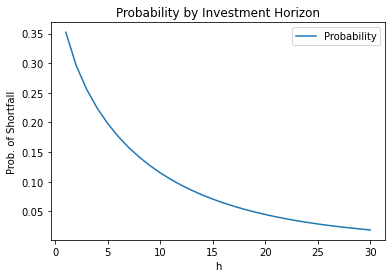

In [140]:
prob_horizon = prob(list(range(1, 31)), mu_tilde, sigma_tilde)

prob_horizon.plot() 
plt.title('Probability by Investment Horizon')
plt.ylabel('Prob. of Shortfall')
plt.show()

### 2.3 Calculating Probabilities 1965-2021

In [215]:
log_df1965 = log_df.loc['1965':].dropna()
mu_tilde = (log_df1965['SPX'].mean()-log_df1965['TB1M'].mean()) * 12
sigma_tilde = (log_df1965['SPX']-log_df1965['TB1M']).std() * np.sqrt(12)

prob(list(range(5,35, 5)), mu_tilde, sigma_tilde)

,Probability
h,
5,0.1976
10,0.1146
15,0.0704
20,0.0445
25,0.0286
30,0.0186


In [216]:
prob([30], mu_tilde, sigma_tilde)

,Probability
h,
30,0.0186


In [217]:
prob([2021-1999], mu_tilde, sigma_tilde)

,Probability
h,
22,0.0373


The probabilities are very similar.

### 2.4 Barnstable's Expectations

(a)

In [218]:
mu = stats_df.iloc[3,0]
bar_r = stats_df.iloc[3,2]
sigma = stats_df.iloc[3,1]

prob([22], mu - bar_r, sigma)

,Probability
h,
22,0.0783


(b)

In [219]:
strike = np.log(1.06)

mu65 = log_df['SPX'].mean() * 12

sigma65 = log_df['SPX'].std() * np.sqrt(12)

mu = 22/8 * (stats_df.iloc[3, 2] - strike) + mu65 - strike

prob([8], mu, sigma65)

,Probability
h,
8,0.1168


## 3 Modeling Volatility and VaR

In [254]:
df[r'$\tilde{r}$'] = df['SPX'] - df['TB1M']
df.dropna(inplace = True)

df.head()

,SPX,TB1M,$\tilde{r}$
date,,,
1926-01-30,-0.0018,0.0031,-0.0048
1926-02-27,-0.0333,0.0026,-0.0359
1926-03-31,-0.0577,0.0026,-0.0603
1926-04-30,0.0385,0.0023,0.0363
1926-05-28,0.0136,0.0027,0.0109


### 3.1 Historic VaR

(a)

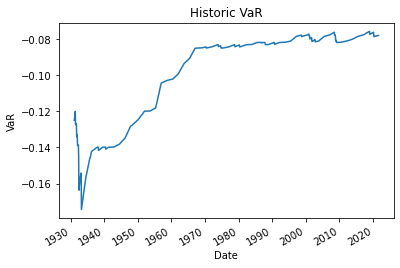

In [257]:
historic_VaR = df[r'$\tilde{r}$'].shift().expanding(min_periods = 60).quantile(.05)
historic_VaR.plot()

plt.title('Historic VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

(b) Frequency of periods where $\tilde{r_{t}} < \tilde{r}^{VaR, .05}_{t, historic}$ 

In [258]:
round(len(df[r'$\tilde{r}$'][df[r'$\tilde{r}$'] < historic_VaR]) / len(historic_VaR.dropna()), 4)

0.0288

(c)
- By definition of VaR, number instances of return should be less than VaR (5%) should be close to 5%, but in our case it is less than 3%
- This method of calculation is valid if there is a smooth tail, and does not give correct result if tails are not smooth

### 3.2 Volatility

Expanding and Rolling Windows:

In [248]:
stdev = np.sqrt((df[r'$\tilde{r}$']**2).shift(1).expanding(60).mean().to_frame('Expanding Window'))

stdev['Rolling Window'] = np.sqrt((df[r'$\tilde{r}$']**2).shift(1).rolling(60).mean())

EWMA:

In [225]:
IGARCH = arch_model(df[r'$\tilde{r}$'])

theta = 0.97

IGARCH.volatility = EWMAVariance(theta)

IGARCH_model = IGARCH.fit()

IGARCH_model.params

Iteration:      1,   Func. Count:      3,   Neg. LLF: 4368087.277886891
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1842.4652930715574
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1842.4652930726525
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2


mu    0.0072
Name: params, dtype: float64

GARCH:

In [262]:
GARCH = arch_model(df[r'$\tilde{r}$'], vol='Garch', p=1, o=0, q=1, dist='Normal')

GARCH_model = GARCH.fit()

GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.6852774436705056e+17
Iteration:      2,   Func. Count:     17,   Neg. LLF: 8260538509987.657
Iteration:      3,   Func. Count:     27,   Neg. LLF: 691678264754941.8
Iteration:      4,   Func. Count:     37,   Neg. LLF: -1893.5015384028798
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1893.5015418394419
            Iterations: 8
            Function evaluations: 37
            Gradient evaluations: 4


mu          7.9792e-03
omega       5.8822e-05
alpha[1]    9.9998e-02
beta[1]     8.7998e-01
Name: params, dtype: float64

(a)

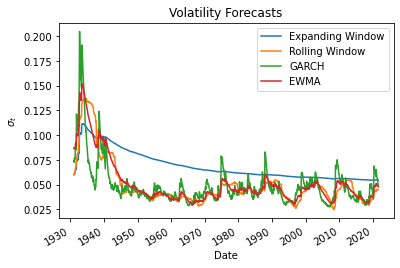

In [263]:
stdev[['GARCH','EWMA']] = None

### Initialize with the given parameter
stdev.iloc[0,2:] = 0.15

### Simulate the rest of the period using the initial stdev given
for i in range(1, len(stdev)):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    stdev['EWMA'].iloc[i] = np.sqrt((stdev['EWMA'].iloc[i-1]**2) * theta \
                                    + (1-theta)*(df[r'$\tilde{r}$'].iloc[i-1]**2))
    stdev['GARCH'].iloc[i] = np.sqrt(GARCH_model.params['omega']\
                                     + (stdev['GARCH'].iloc[i-1]**2) * GARCH_model.params['beta[1]']\
                                     + GARCH_model.params['alpha[1]']*(df[r'$\tilde{r}$'].iloc[i-1]**2))
    
stdev.dropna(inplace = True)

stdev.plot()

plt.title('Volatility Forecasts')
plt.ylabel(r'$\sigma_{t}$')
plt.xlabel('Date')
plt.show()

(b)

In [264]:
VaR = -1.65 * stdev
VaR.head()

,Expanding Window,Rolling Window,GARCH,EWMA
date,,,,
1931-01-31,-0.0992,-0.0992,-0.1228,-0.1434
1931-02-28,-0.0992,-0.1000,-0.1198,-0.1422
1931-03-31,-0.1010,-0.1024,-0.1268,-0.1436
1931-04-30,-0.1013,-0.1027,-0.125,-0.1428
1931-05-29,-0.1023,-0.1043,-0.1276,-0.1431


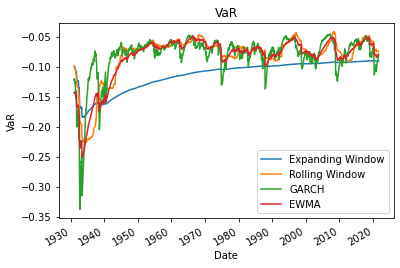

In [265]:
VaR.plot()

plt.title('VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

(c)

In [269]:
freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[df.loc[VaR.index, r'$\tilde{r}$'] < VaR[col]]) / len(VaR[col].dropna().index)
    
round(freq_df, 4)

,Expanding Window,Rolling Window,GARCH,EWMA
Frequency,0.0177,0.0483,0.0446,0.0418


## 4 Extensions 

### 4.1 Performance Probabilities w/ Excess Returns

(a)

In [270]:
mu_tilde = stats_df.iloc[4,0]
bar_r_tilde = stats_df.iloc[4,2]
sigma_tilde = stats_df.iloc[4,1]

prob([22], mu_tilde - bar_r_tilde, sigma_tilde)

,Probability
h,
22,0.5181


(b)

In [271]:
mu = 22/8 * (stats_df.iloc[4, 2]) + stats_df.iloc[4, 4] 

prob([8], mu, stats_df.iloc[4,5])

,Probability
h,
8,0.0003


(c) Barnstable is susceptible to the fact that the mean of the risk-free rate changes. The strike of the puts is based on historic risk-free data, which results in a higher strike than expected if the risk-free rate decreases (which it does very significantly in the years after the option contract is decided). Barnstable could have used a floating risk-free rate as its strike growth parameter, which would have accounted for this, and would not have made any assumptions about what the mean of the risk-free rate would be in the coming years. 

### 4.2 Confidence Intervals

(a)

In [272]:
conf_interval = pd.DataFrame(data = None, index = [0.05, 0.95], columns = [r'$\tilde{\mu}_{q}$'])

### Use 1965-1999
mu_tilde = stats_df.iloc[4,0]
sigma_tilde = stats_df.iloc[4,1]

### use norm.ppf() to find the z-score
conf_interval[conf_interval.columns[0]] = mu_tilde + stats.norm.ppf(conf_interval.index)*sigma_tilde

round(conf_interval,4)

,$\tilde{\mu}_{q}$
0.05,-0.1911
0.95,0.3037


(b)

At $\tilde{\mu}_{0.05}$:

In [273]:
mu_tilde_05 = conf_interval.loc[0.05][0]
bar_r_tilde = stats_df.iloc[4,2]
sigma_tilde = stats_df.iloc[4,1]

prob([22], mu_tilde_05 - bar_r_tilde, sigma_tilde)

,Probability
h,
22,1.0


At $\tilde{\mu}_{0.95}$:

In [235]:
mu_tilde_95 = conf_interval.loc[0.95][0]

prob([22], mu_tilde_95 - bar_r_tilde, sigma_tilde)

,Probability
h,
22,8.6300e-15


(c)

In [236]:
round(conf_interval,4)

,$\tilde{\mu}_{q}$
0.05,-0.1911
0.95,0.3037


In [237]:
round(stats_df[r'2000-2021 $\mu$'].to_frame(),4)

,2000-2021 $\mu$
$r^{M}$,0.0840
${\tilde{r}^{M}}$,0.0693
$r^{f}$,0.0147
log $r^{M}$,0.0724
log ${\tilde{r}^{M}}$,0.0577
log $r^{f}$,0.0147


No, $\mu$ from 2000-2021 has not been outside the confidence interval defined by the 1965-1999 data.

(d) From the data we have looked at, it appears that excess return mean is much more stationary than SPY return mean or risk-free rate mean, and we can create better future estimates of excess return mean. Consequently, it makes sense not to enter a contract where a strike (or rate of return paid out, e.g. in the trust) is based off a historical risk-free rate and is set as a constant. Barnstable should find a proposal where their exposure is the risk-free rate. 

### 4.3 Log-Normal Distribution

(a)

In [238]:
def log_mu(level_mu, log_sigma):
    return np.log(level_mu + 1) - 0.5 * (log_sigma**2)

In [239]:
print('Mean log return of stocks: ' + str(round(log_mu(.13, .16), 4)))

Mean log return of stocks: 0.1094


No, this is not the same as the 11.72% given in the case.

(b)

In [240]:
def level_var(level_mu, log_sigma):
    log_mu_ = log_mu(level_mu, log_sigma)
    return np.exp(2*log_mu_ + log_sigma) * (np.exp(log_sigma**2) - 1)

In [241]:
print('Variance of level return of stocks: ' + str(round(level_var(.13, .16), 4)))

Variance of level return of stocks: 0.0379


In [242]:
print('Standard deviation of level return of stocks: ' + str(round(np.sqrt(level_var(.13, .16)), 4)))

Standard deviation of level return of stocks: 0.1946


(c) Mean and volatility are larger for level returns.

### 4.4
Does the analysis change much if we use the pre-1965 data in our estimates of the market return
and risk-free rate?
<br>

Yes it should change quite a bit, as volatility for stocks is much higher, and excess return is much higher for the period, due to the mean of $r^{f}$ being much lower. 

In [243]:
round(annualized_stats(df.loc[:'1965'], 12), 4)

,1926-1965 $\mu$,1926-1965 $\sigma$
$r^{M}$,0.1198,0.2304
${\tilde{r}^{M}}$,0.1049,0.2304
$r^{f}$,0.0149,0.0039


In [244]:
round(stats_df, 4)

,1965-1999 $\mu$,1965-1999 $\sigma$,2000-2021 $\mu$,2000-2021 $\sigma$,1926-2021 $\mu$,1926-2021 $\sigma$
$r^{M}$,0.1294,0.1494,0.0840,0.1499,0.1157,0.1872
${\tilde{r}^{M}}$,0.0679,0.1502,0.0693,0.1505,0.0839,0.1879
$r^{f}$,0.0615,0.0072,0.0147,0.0050,0.0318,0.0086
log $r^{M}$,0.1176,0.1496,0.0724,0.1510,0.0979,0.1865
log ${\tilde{r}^{M}}$,0.0563,0.1504,0.0577,0.1516,0.0662,0.1872
log $r^{f}$,0.0613,0.0071,0.0147,0.0050,0.0317,0.0085
